In [2]:
!pip install git+https://gitlab.com/Xiangyan93/graphdot.git@feature/xy descriptastorus mgktools shap

  Cloning https://gitlab.com/Xiangyan93/graphdot.git (to revision feature/xy) to /tmp/pip-req-build-fmhn89tu
  Running command git clone --filter=blob:none --quiet https://gitlab.com/Xiangyan93/graphdot.git /tmp/pip-req-build-fmhn89tu
  Running command git checkout -b feature/xy --track origin/feature/xy
  Switched to a new branch 'feature/xy'
  Branch 'feature/xy' set up to track remote branch 'feature/xy' from 'origin'.
  Resolved https://gitlab.com/Xiangyan93/graphdot.git to commit a092ee06670620f2ebce73530d7d16a2cef1cde3
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 15.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.6/55.6 kB 7.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━

In [2]:
import pandas as pd
import numpy as np
import random
import json
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import shap
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from descriptastorus.descriptors.rdDescriptors import RDKIT_PROPS
from mgktools.data.data import Dataset
from mgktools.features_mol.features_generators import FeaturesGenerator
np.random.seed(0)
random.seed(0)

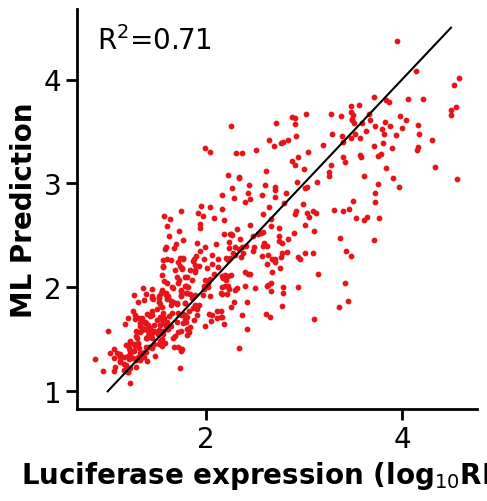

In [7]:
fs = 8
params = {'legend.fontsize': '%s' % (2 * fs),
          'figure.figsize': (fs / 2, fs / 2),  # 8*6
          'axes.labelsize': '%s' % (2.5 * fs),
          'axes.titlesize': '%s' % (2 * fs),
          'xtick.labelsize': '%s' % (2.5 * fs),
          'ytick.labelsize': '%s' % (2.5 * fs),
          # 'font.family': 'Arial',
          'axes.linewidth': fs / 4,
          }
pylab.rcParams.update(params)
fig = plt.figure()
fig.tight_layout()

ax = fig.add_axes([0,0,1,1])
df = pd.read_csv('../data/5fold.csv')
df = df[(df.representation == 'r1+r2')&(df.model == 'RF-RDKit') & (df.seed == 0)]
x = df['truth'].apply(lambda x: json.loads(x)).sum()
y = df['predict'].apply(lambda x: json.loads(x)).sum()
ax.scatter(x, y, color='#E7141A', s=10)
ax.plot([1, 4.5], [1, 4.5], 'k')
ax.text(0.05, 0.9, r'R$^2$=%.2f' % r2_score(x, y), transform=ax.transAxes, fontsize=20)
ax.set_xlabel(r'Luciferase expression (log$_{10}$RLU)', fontweight='bold')
ax.set_ylabel("ML Prediction", fontweight='bold')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(length=8, width=2)

plt.savefig('figure1e.svg', format='svg', dpi=1200, bbox_inches='tight')

In [3]:
dataset = Dataset.from_df(
        df=pd.read_csv('../data/luciferase_expression.csv'),
        smiles_columns=["reactant1", "reactant2"],
        targets_columns=['logv'],
        n_jobs=1,
    )
fgs = [FeaturesGenerator(features_generator_name=fg) for fg in ["rdkit_2d_normalized"]]
dataset.set_status(graph_kernel_type="no",
                   features_generators=fgs,
                   features_combination="concat")
X = dataset.X
y = dataset.y
rdkit_names = RDKIT_PROPS['1.0.0']
feature_names = [f'Head-{n}' for n in rdkit_names] + [f'Tail-{n}' for n in rdkit_names]
X = pd.DataFrame(X, columns=feature_names)
model = RandomForestRegressor()
model.fit(X, y)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestRegressor()

Text(0, 0.5, 'Feature value')

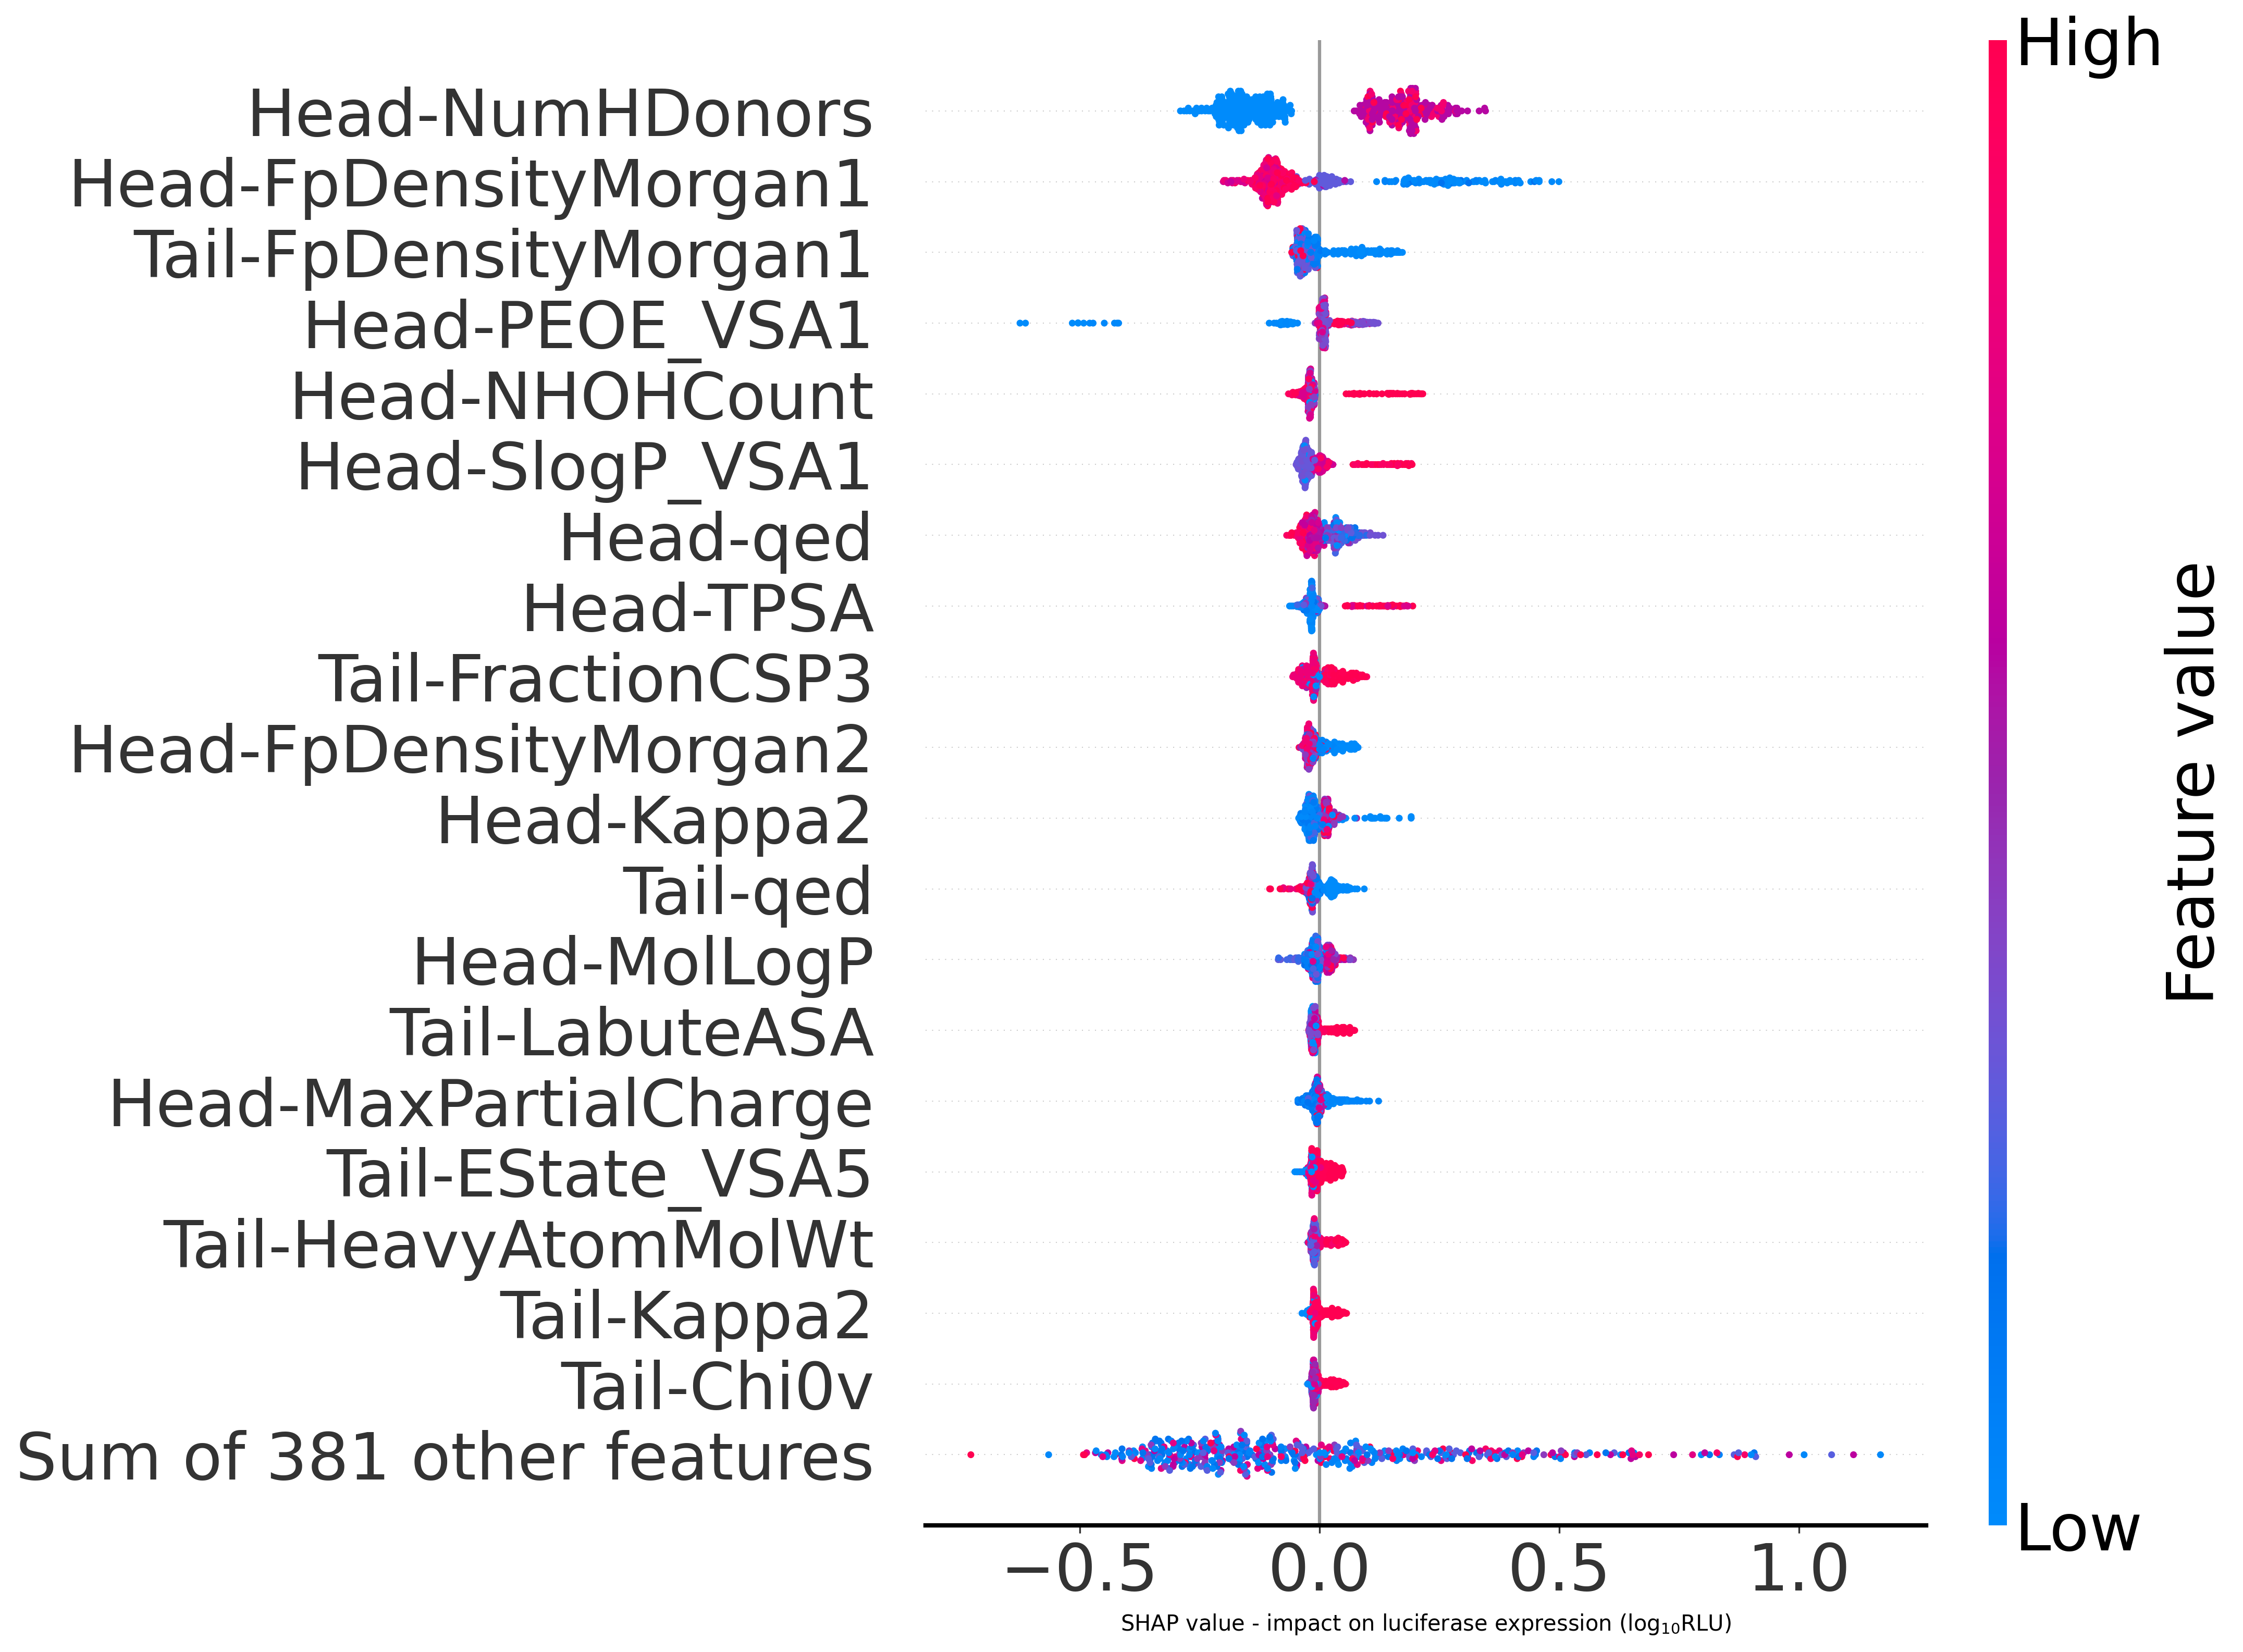

In [ ]:
fs = 2
params = {
    'legend.fontsize': '%s' % (4. * fs),
    'figure.figsize': (3, 3),  # 10*2
    'axes.labelsize': '%s' % (8 * fs),
    'axes.titlesize': '%s' % (8 * fs),
    'axes.linewidth': 2,
    'xtick.labelsize': '%s' % (8 * fs),
    'ytick.labelsize': '%s' % (8 * fs),
    # 'font.family': 'Arial',
    'savefig.dpi': 300,
    'figure.dpi': 300,
}
pylab.rcParams.update(params)
fig = plt.figure()
fig.tight_layout()
ax = fig.add_axes([0,0,1,1])

explainer = shap.Explainer(model, seed=0)
shap_values = explainer(X)
ax = shap.plots.beeswarm(shap_values, max_display=20, show=False, s=10)
ax.tick_params(axis='both', which='major', labelsize=30)
ax.set_xlabel(r'SHAP value - impact on luciferase expression (log$_{10}$RLU)', size=10)
cbar = ax._colorbars[0]
cbar.tick_params(labelsize=30)
cbar.set_ylabel('Feature value', size=30)

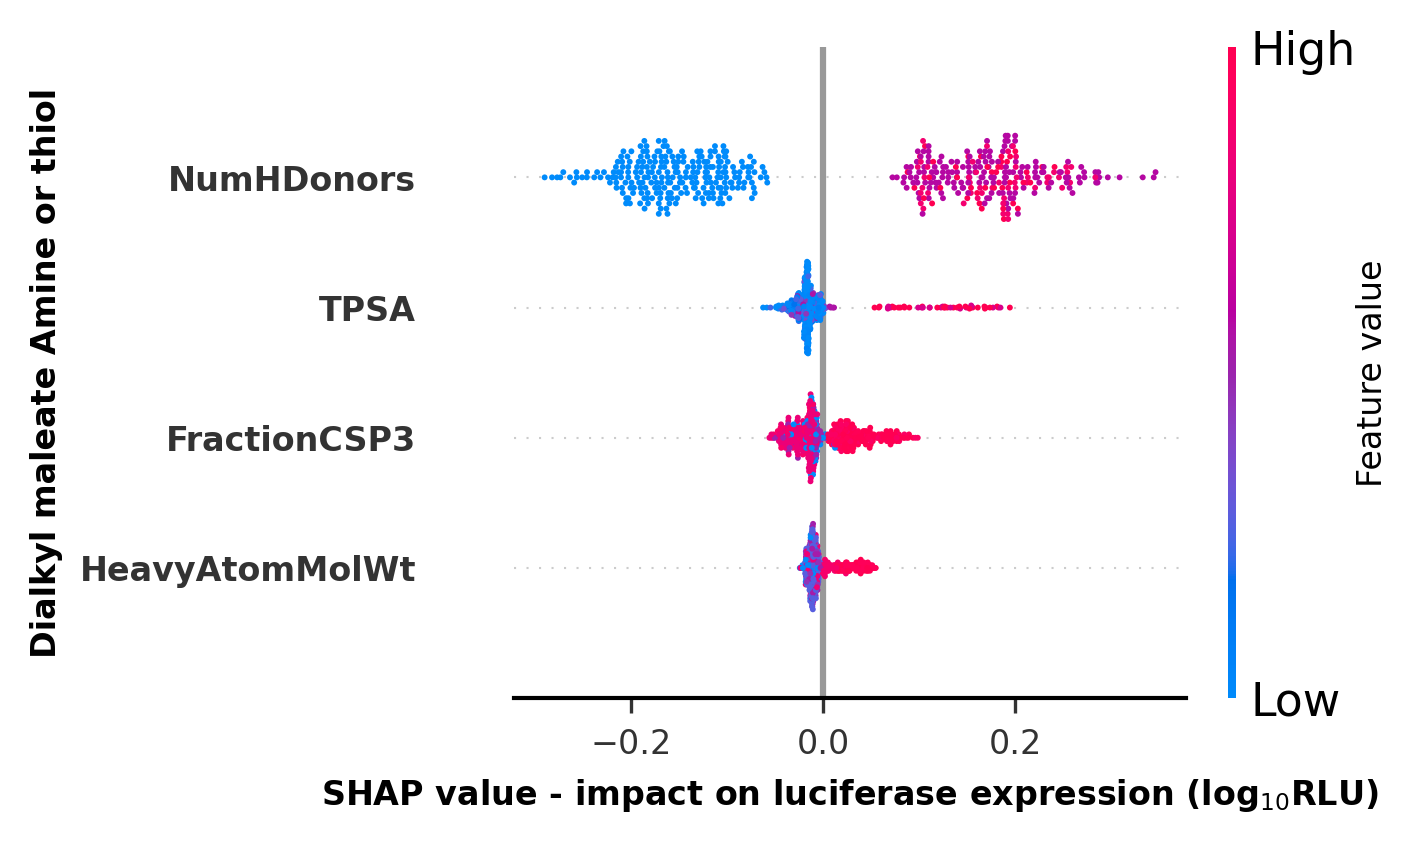

In [ ]:
fs = 8
params = {
    'legend.fontsize': '%s' % (1. * fs),
    'figure.figsize': (fs * 2, fs * 2),  # 10*2
    'axes.labelsize': '%s' % (1 * fs),
    'axes.titlesize': '%s' % (1 * fs),
    'axes.linewidth': 1,
    'xtick.labelsize': '%s' % (2 * fs),
    'ytick.labelsize': '%s' % (2 * fs),
    # 'font.family': 'Arial',
    'savefig.dpi': 300,
    'figure.dpi': 300,
}
pylab.rcParams.update(params)
fig = plt.figure()
fig.tight_layout()

ax = fig.add_axes([0,0,0.35,0.7])
selected_features_ = ['NumHDonors', 'TPSA']
selected_features = ["Head-%s" % f for f in selected_features_]
selected_features_ += ['FractionCSP3', 'HeavyAtomMolWt', ]
selected_features += ["Tail-%s" % f for f in selected_features_[-2:]]
feature_names = shap_values.feature_names
selected_feature_indices = [feature_names.index(feature) for feature in selected_features if feature in feature_names]

selected_feature_names = [shap_values.feature_names[i] for i in selected_feature_indices]

# Filter the SHAP values and feature names
filtered_shap_values = shap.Explanation(
    values=shap_values.values[:, selected_feature_indices],
    base_values=shap_values.base_values,
    data=shap_values.data[:, selected_feature_indices],
    feature_names=selected_feature_names
)

ax = shap.plots.beeswarm(filtered_shap_values, max_display=len(selected_features), show=False, s=2, order=[0, 1, 2, 3], alpha=1)
# Apply your formatting
ax.tick_params(axis='both', which='major', labelsize=fs)
ax.set_xlabel(r'SHAP value - impact on luciferase expression (log$_{10}$RLU)', size=fs, fontweight='bold')
ax.set_yticklabels(selected_features_[::-1], fontweight='bold')
cbar = ax._colorbars[0]
cbar.set_ylabel('Feature value', size=fs)
cbar.set_aspect(80)
ax.set_ylabel("Dialkyl maleate Amine or thiol", fontweight='bold')
plt.savefig('figure1f.svg', format='svg', dpi=1200, bbox_inches='tight')

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished


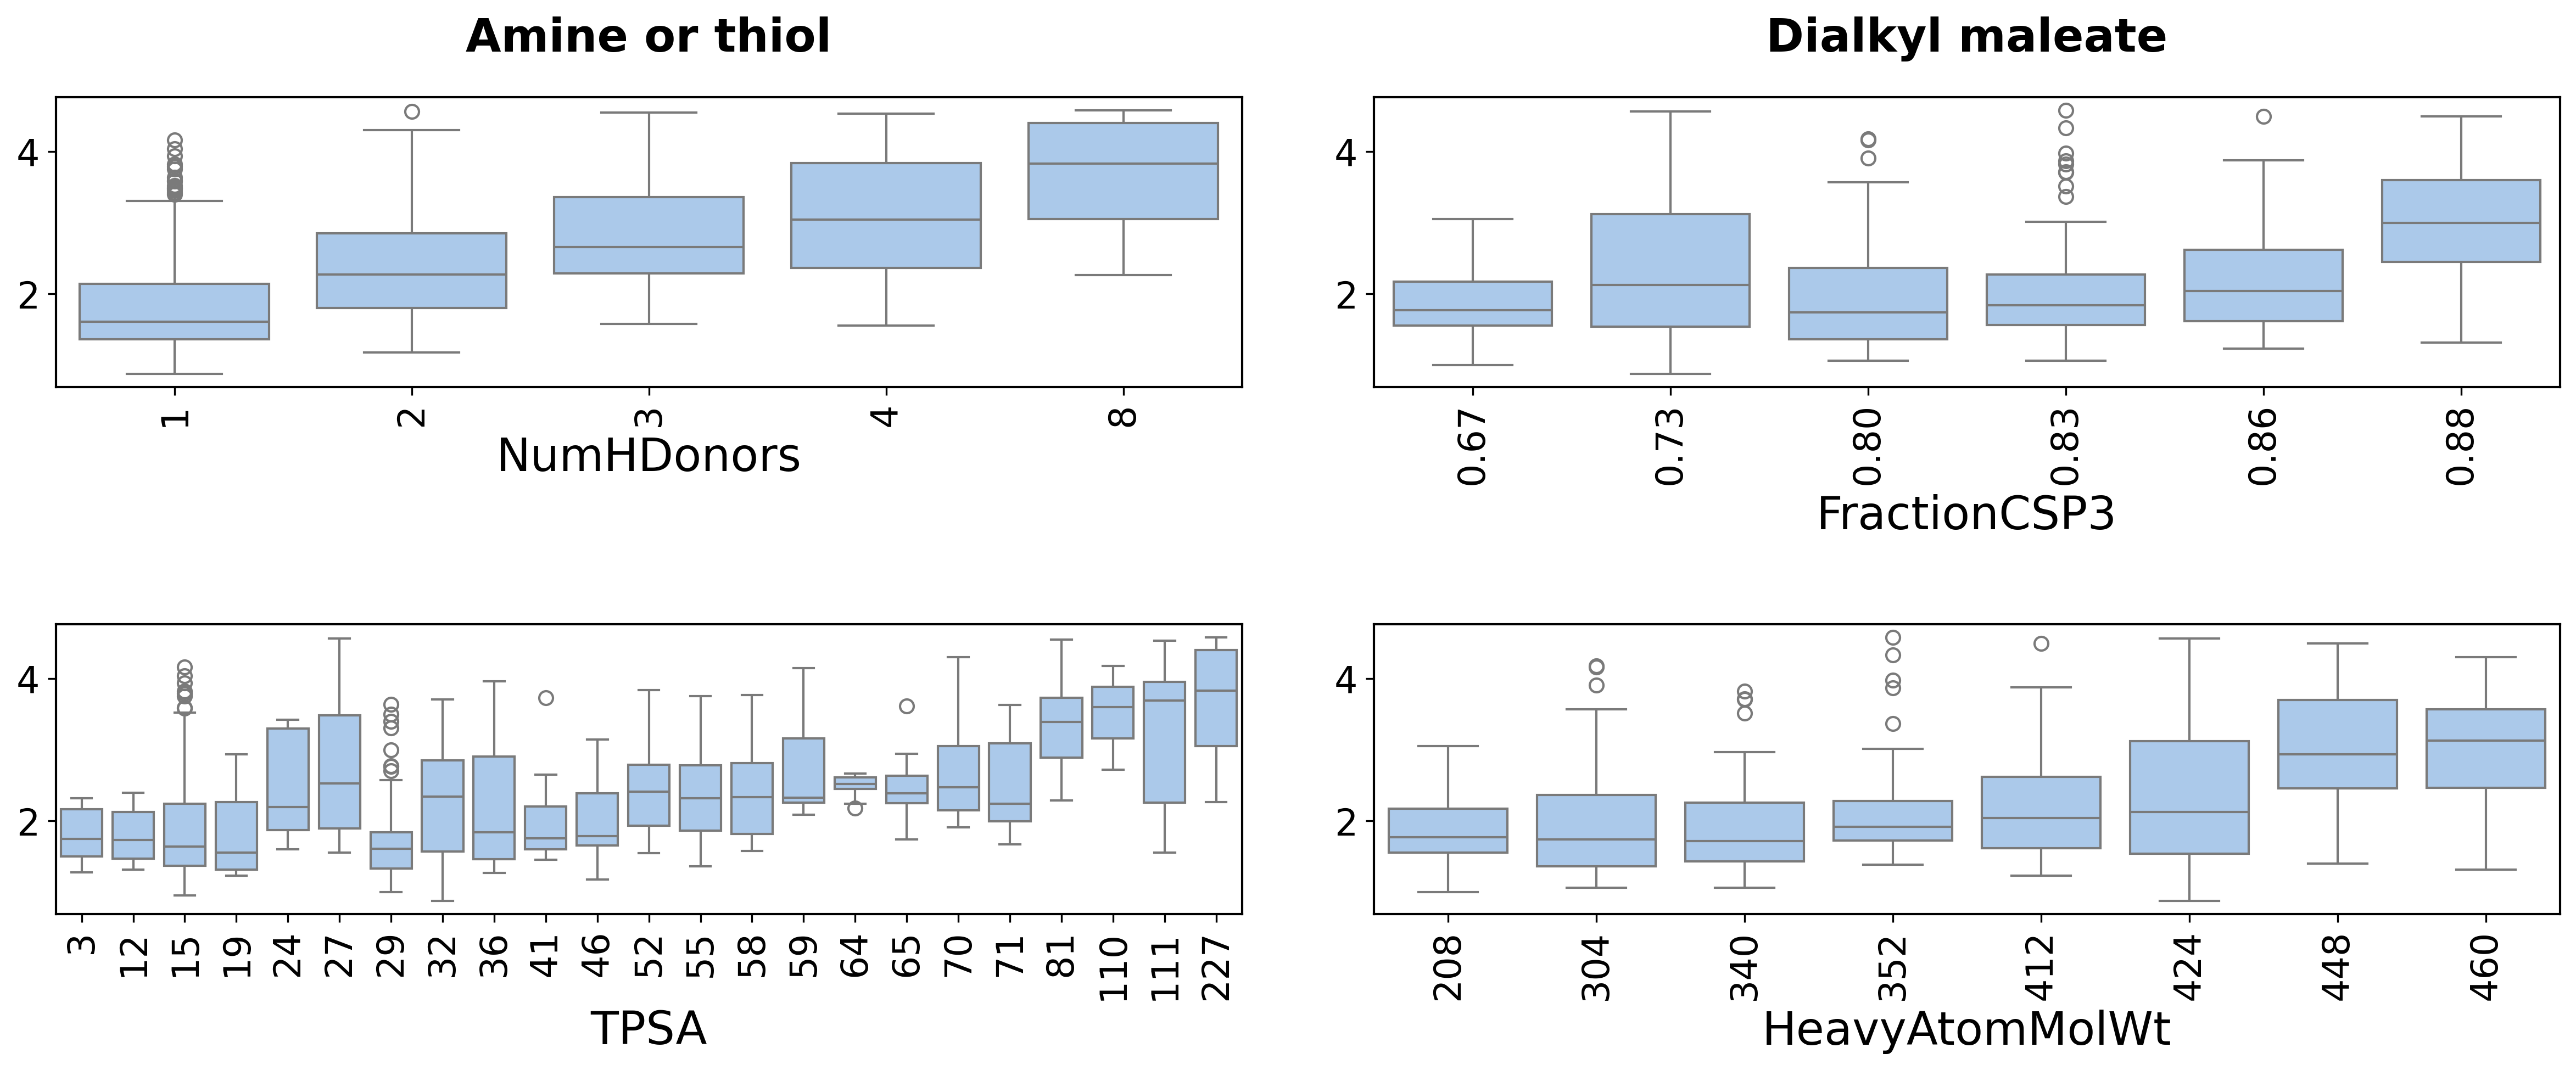

In [4]:
import seaborn as sns
fs = 8
params = {
    'legend.fontsize': '%s' % (2. * fs),
    'figure.figsize': (fs * 2, fs * 2),  # 10*2
    'axes.labelsize': '%s' % (2.5 * fs),
    'axes.titlesize': '%s' % (2.5 * fs),
    'axes.linewidth': 1,
    'xtick.labelsize': '%s' % (2 * fs),
    'ytick.labelsize': '%s' % (2 * fs),
    # 'font.family': 'Arial',
    # 'font.serif': 'calibri',
    'savefig.dpi': 300,
    'figure.dpi': 300,
}
pylab.rcParams.update(params)
fig = plt.figure()
fig.tight_layout()

pastel_colors_hex = sns.color_palette("pastel").as_hex()

dataset = Dataset.from_df(
        df=pd.read_csv('../data/luciferase_expression.csv'),
        smiles_columns=["reactant1", "reactant2"],
        targets_columns=['logv'],
        n_jobs=1,
    )
fgs = [FeaturesGenerator(features_generator_name=fg) for fg in ["rdkit_2d"]]
dataset.set_status(graph_kernel_type="no",
                   features_generators=fgs,
                   features_combination="concat")
X = dataset.X
y = dataset.y
feature_names = [f'Head-{n}' for n in rdkit_names] + [f'Tail-{n}' for n in rdkit_names]
X = pd.DataFrame(X, columns=feature_names)

for i, p in enumerate(['NumHDonors', 'TPSA']):
    ax = fig.add_axes([0, 0.8 - i * 0.2, 0.45, 0.11])
    df = pd.DataFrame({})
    df['Head'] = [j for j in range(1, 51) for i in range(1, 11)]
    df['Tail'] = ['D4', 'D6.2', 'D8', 'D8i', 'D18', 'D9.2', 'D9.8', 'D11.1', 'D11.10', 'D12.8'] * 50
    df['p'] = X['Head-%s' % p]
    df['y'] = y.ravel()
    p2x = {}
    for _, g in df.groupby('p'):
        if i in [0,2,3,4]:
            p2x[_] = '%.0f' % _#  + ' (' + ','.join([str(i) for i in g.Head.unique()]) + ')'
        else:
            p2x[_] = '%.0f' % _
    df['X'] = df['p'].apply(lambda x: p2x[x])
    sns.boxplot(df, x='X', y='y', order=p2x.values(), color=pastel_colors_hex[0])
    ax.tick_params(axis='x', rotation=90)
    ax.set_xlabel(p)
    if i == 2:
        ax.set_ylabel(r'luciferase expression (log$_{10}$RLU)')
    else:
        ax.set_ylabel('')
    if i == 0:
        ax.set_title("Amine or thiol", fontweight='bold', pad=20)

for i, p in enumerate(['FractionCSP3', 'HeavyAtomMolWt']):
    ax = fig.add_axes([0.5, 0.8 - i * 0.2, 0.45, 0.11])
    df = pd.DataFrame({})
    df['Head'] = [j for j in range(1, 51) for i in range(1, 11)]
    df['Tail'] = ['D4', 'D6.2', 'D8', 'D8i', 'D18', 'D9.2', 'D9.8', 'D11.1', 'D11.10', 'D12.8'] * 50
    df['p'] = X['Tail-%s' % p]
    df['y'] = y.ravel()
    p2x = {}
    for _, g in df.groupby('p'):
        if i in [0]:
            p2x[_] = '%.2f' % _#  + ' (' + ','.join([str(i) for i in g.Head.unique()]) + ')'
        else:
            p2x[_] = '%.0f' % _
    df['X'] = df['p'].apply(lambda x: p2x[x])
    sns.boxplot(df, x='X', y='y', order=p2x.values(), color=pastel_colors_hex[0])
    ax.tick_params(axis='x', rotation=90)
    ax.set_xlabel(p)
    ax.set_ylabel('')
    if i == 0:
        ax.set_title("Dialkyl maleate", fontweight='bold', pad=20)
plt.savefig('Sfigure5.svg', format='svg', dpi=300, bbox_inches='tight')

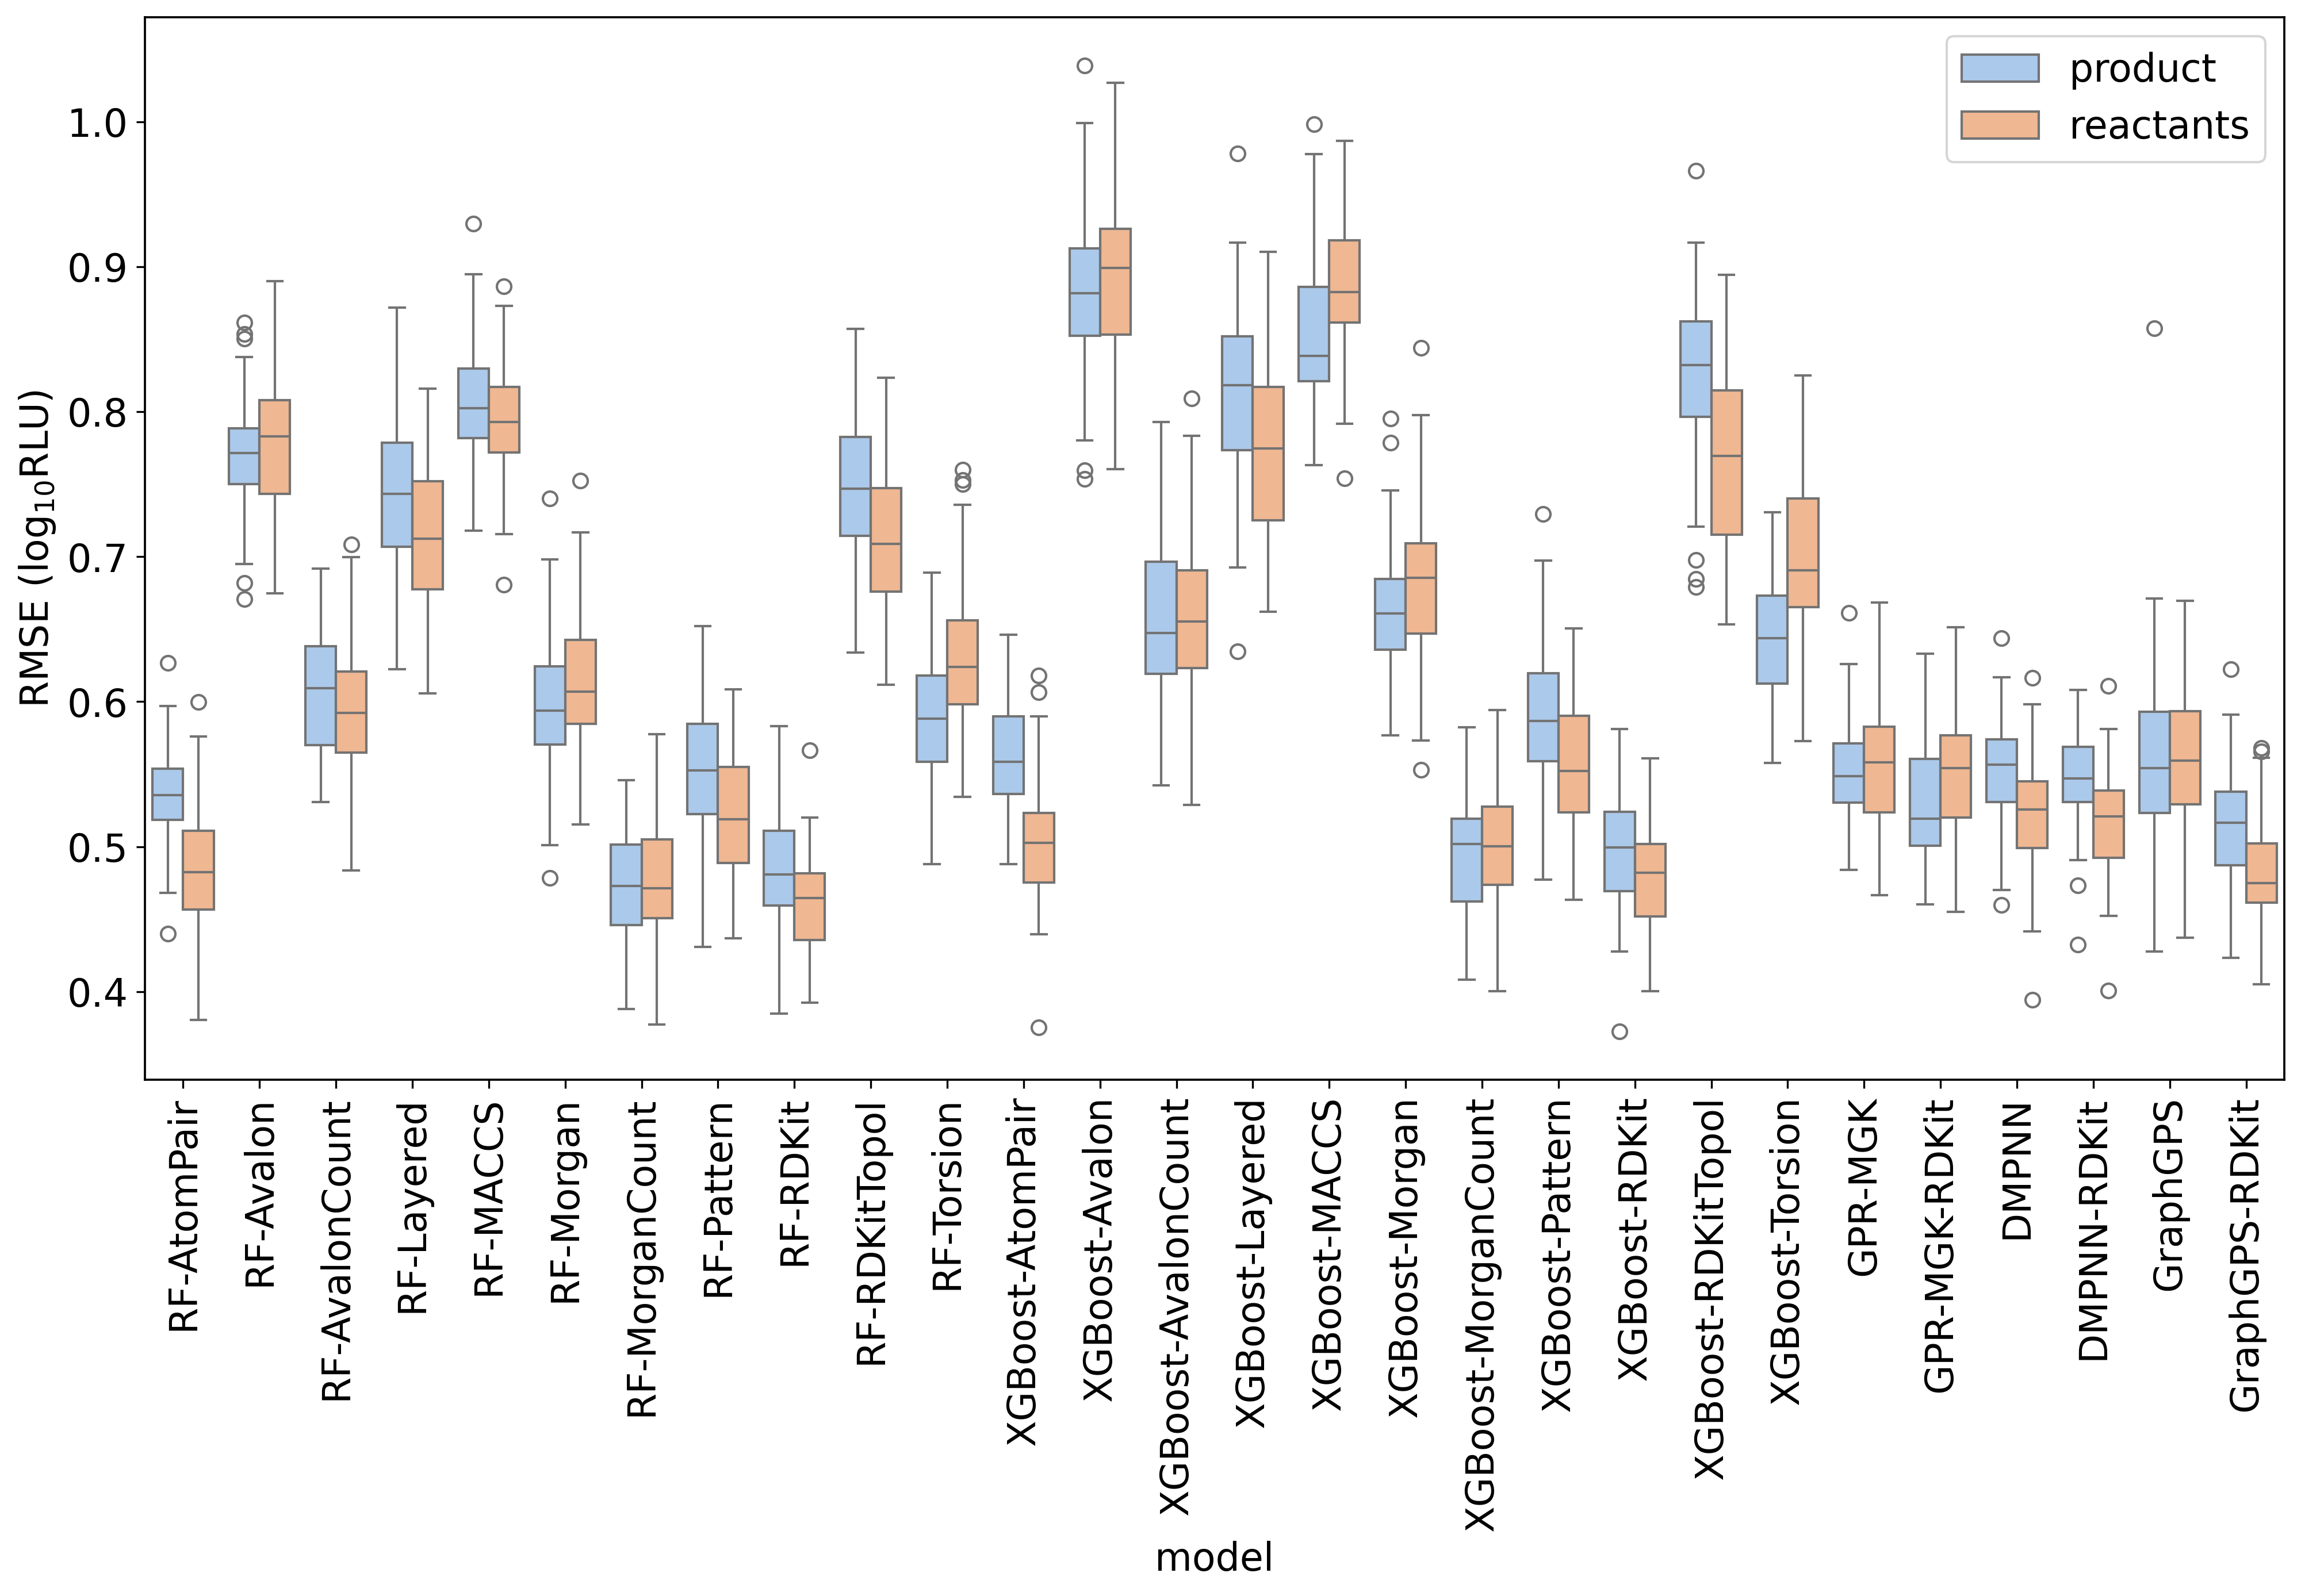

In [5]:
fs = 8
params = {'legend.fontsize': '%s' % (2 * fs),
          'figure.figsize': (fs * 2, fs * 1),  # 8*6
          'axes.labelsize': '%s' % (2 * fs),
          'axes.titlesize': '%s' % (2 * fs),
          'xtick.labelsize': '%s' % (2 * fs),
          'ytick.labelsize': '%s' % (2 * fs),
          # 'font.family': 'Arial',
          'axes.linewidth': fs / 9,
          'image.cmap': 'viridis'
          }
pylab.rcParams.update(params)
fig = plt.figure()
fig.tight_layout()
plt.rcParams.update(params)

df = pd.read_csv("../data/5fold.csv")
df['representation'] = df['representation'].apply(lambda x: "reactants" if x == 'r1+r2' else "product")
sns.boxplot(data=df, x="model", y="rmse", hue="representation", palette='pastel', hue_order=['product', 'reactants'])
# sns.stripplot(data=df, x="model", y="rmse", hue="representation")
plt.ylabel(r"RMSE (log$_{10}$RLU)")
plt.xticks(rotation=90)
plt.legend()
plt.savefig('Sfigure3.svg', format='svg', dpi=1200, bbox_inches='tight')

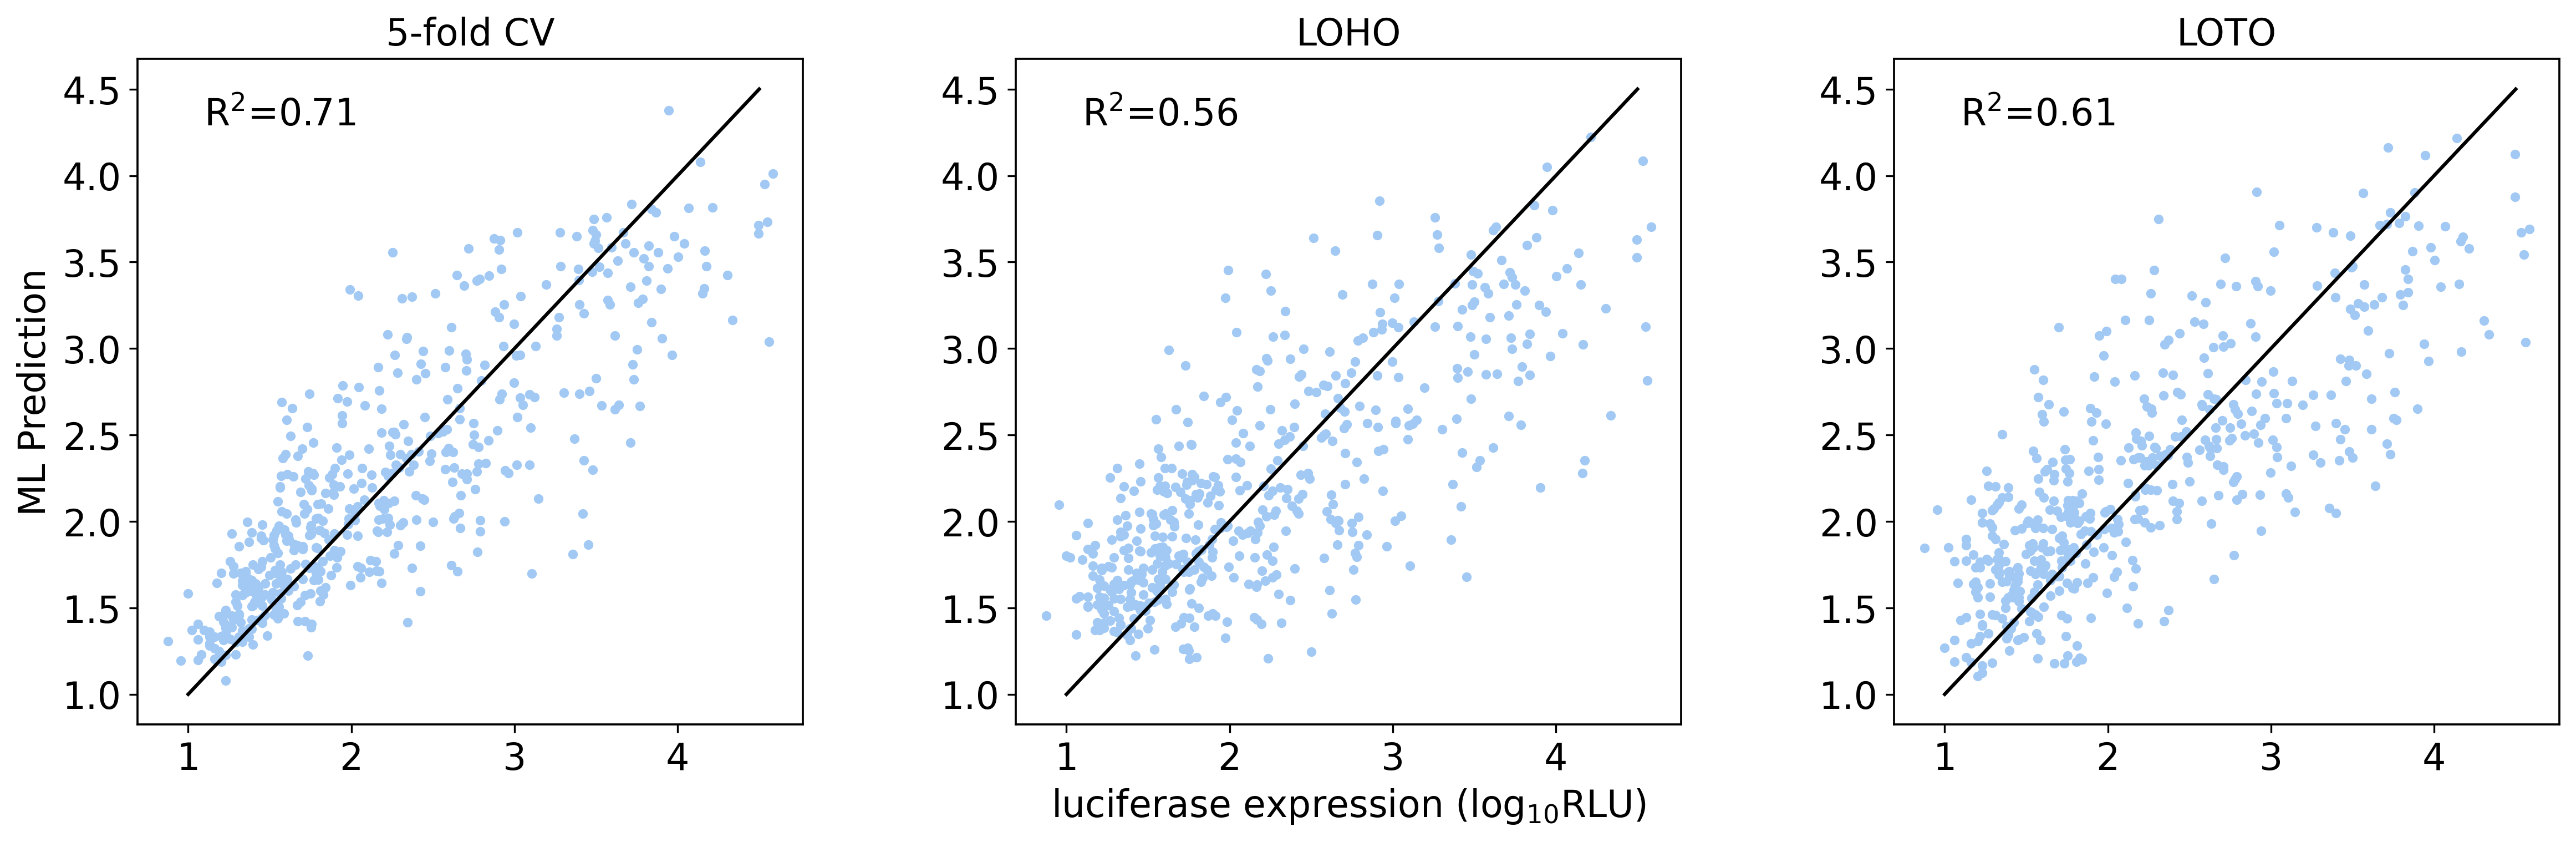

In [ ]:
fs = 8
params = {'legend.fontsize': '%s' % (2 * fs),
          'figure.figsize': (fs * 2, fs * 2),  # 8*6
          'axes.labelsize': '%s' % (2 * fs),
          'axes.titlesize': '%s' % (2 * fs),
          'xtick.labelsize': '%s' % (2 * fs),
          'ytick.labelsize': '%s' % (2 * fs),
          # 'font.family': 'Arial',
          'axes.linewidth': fs / 9,
          'image.cmap': 'viridis'
          }
pylab.rcParams.update(params)
fig = plt.figure()
fig.tight_layout()
plt.rcParams.update(params)

ax = fig.add_axes([0,0,0.25,0.25])
df = pd.read_csv('../data/5fold.csv')
df = df[(df.representation == 'r1+r2')&(df.model == 'RF-RDKit') & (df.seed == 0)]
x = df['truth'].apply(lambda x: json.loads(x)).sum()
y = df['predict'].apply(lambda x: json.loads(x)).sum()
ax.scatter(x, y, color=pastel_colors_hex[0], s=10)
ax.plot([1, 4.5], [1, 4.5], 'k')
ax.text(0.1, 0.9, r'R$^2$=%.2f' % r2_score(x, y), transform=ax.transAxes, fontsize=16)
ax.set_xlabel("")
ax.set_ylabel("ML Prediction")
ax.set_title('5-fold CV')

ax = fig.add_axes([0.33,0,0.25,0.25])
df = pd.read_csv('../data/LOHO.csv')
x = df['truth'].apply(lambda x: json.loads(x)).sum()
y = df['predict'].apply(lambda x: json.loads(x)).sum()
ax.scatter(x, y, color=pastel_colors_hex[0], s=10)
ax.plot([1, 4.5], [1, 4.5], 'k')
ax.text(0.1, 0.9, r'R$^2$=%.2f' % r2_score(x, y), transform=ax.transAxes, fontsize=16)
ax.set_xlabel(r"luciferase expression (log$_{10}$RLU)")
ax.set_ylabel("")
ax.set_title('LOHO')

ax = fig.add_axes([0.66,0,0.25,0.25])
df = pd.read_csv('../data/LOTO.csv')
x = df['truth'].apply(lambda x: json.loads(x)).sum()
y = df['predict'].apply(lambda x: json.loads(x)).sum()
ax.scatter(x, y, color=pastel_colors_hex[0], s=10)
ax.plot([1, 4.5], [1, 4.5], 'k')
ax.text(0.1, 0.9, r'R$^2$=%.2f' % r2_score(x, y), transform=ax.transAxes, fontsize=16)
# ax.set_xlabel(r"$\it{in\ vitro}$ luciferase expression (log$_{10}$RLU)")
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_title('LOTO')
plt.savefig('Sfigure4.svg', format='svg', dpi=1200, bbox_inches='tight')